<a href="https://colab.research.google.com/github/crux82/BISS-2024/blob/main/BISS_2024_Lab_1_Training_BERT_based_models_in_few_lines_of_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lectures on Computational Linguistics 2021**

# Tranining a sentence classifier using BERT-based models (in Pytorch and compatible with HuggingFace)

**Author**: Danilo Croce


This is a Pytorch (+ **Huggingface** transformers) implementation of a "simple" text classifier defined using BERT-based models.
In this lab we will see how it is simple to use BERT for a sentence classification task, obtaining state-of-the-art results in few lines of python code.

In a nutshell, we will "implement" this architecture:

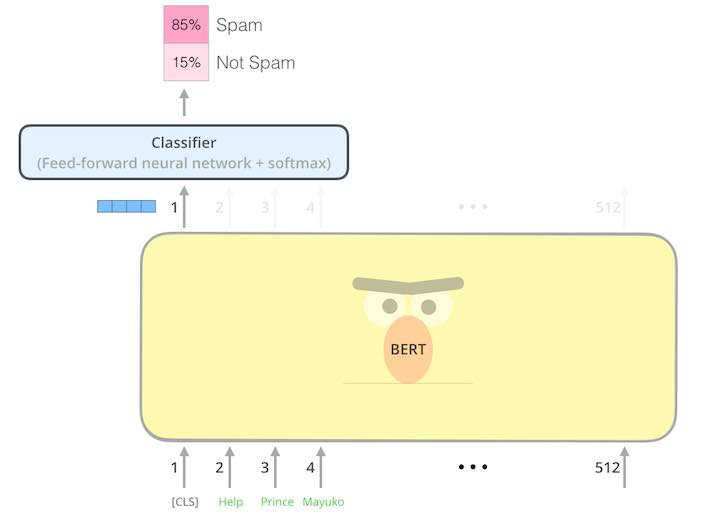

Given an input sentence, we will use a BERT-based architecture to encode it and a linear classifier is used to associate the produced vector to one of the `c` classes considered in the classification task.

Most importantly, we will show how to use the same code but using different transformer based architectures, such as:
- RoBERTa or Electra in English;
- multilingual BERT or XLMRoBERTA;
- specific encoders trained on Italian corpora.

Moreover, we will evaluate our code in two sentence classification tasks:
- Question Classification in English
- Subjectivity identification in Italian

by (hopefully) changing only one or two lines of code.
_________________
**Prerequisites**:
 - You should know the basics of neural learning for NLP tasks. A *very* good introduction can be found here: https://arxiv.org/abs/1510.00726
 - You should have basic notions about training a neural network in Pytorch. You can find an introduction here: https://pytorch.org/tutorials/beginner/basics/intro.html
_________________

For additional information on BERT:
- https://www.aclweb.org/anthology/N19-1423/

A more intuitive introduction to BERT can be found here:
- http://jalammar.github.io/illustrated-bert/

A more detailed analysis of BERT can be found here:
- Dissecting BERT - Part 1: https://medium.com/dissecting-bert/dissecting-bert-part-1-d3c3d495cdb3
- Dissecting BERT - Part 2: https://medium.com/dissecting-bert/dissecting-bert-part2-335ff2ed9c73
- Dissecting BERT - Appendix: https://medium.com/dissecting-bert/dissecting-bert-appendix-the-decoder-3b86f66b0e5f

A brief summary of the last 10 years and how we got to BERT:
- https://neptune.ai/blog/bert-and-the-transformer-architecture-reshaping-the-ai-landscape


The wide plethora of models available in Huggingface is avaliable here:
- https://huggingface.co/models

**Let's GO!**

You can just modify the parameter at the step 2 where the task is specified (e.g., `task = "qc"` VS `task = "subj"`) and the `model_name` and then run the entire process.

## **Step 0**: Python Imports

In [ ]:
!pip install transformers==4.37.2

import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt

##Set random values
seed_val = 213
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

We then check if a GPU is made available for training the architecture. We can also use CPUs but it is "quite" slow.

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## **Step 1**: Select the task and dataset

### **Task 1**: Question classification Task

Given a question in natural language, a classifier associates it to a class reflecting the aim. E.g., "*Who is Galileo?*" refers to a `PERSON` while "*Where is Rome?*" refers to a `LOCATION`.
We will use the **Question Classification** dataset (in English) available here:
- https://cogcomp.seas.upenn.edu/Data/QA/QC/

where questions are associated to classes at different level of granularity:
- coarse-grained: 6 classes
- fined-grained: 50 classes

### **Task 2**: Subjectivity identification in Twitter

Given a tweet, the task is to detect the expression of subjectivity in terms of a binary classification task (`objective` VS `subjective` class). We will use the **Sentipolc** Dataset (in Italian) available here:
- http://www.di.unito.it/~tutreeb/sentipolc-evalita16/data.html

**IMPORTANT**: here we did not apply any pre-processing... however in many cases (especially in Twitter) it can be very usefull, e.g., by normalizing cited users with `@users`.

First, we define two methods to load the datasets.

In [ ]:
import csv

def load_qc_examples(input_file, use_fine_grained_classes = False):
  """Creates examples for the training and dev sets."""
  examples = []
  labels = []

  with open(input_file, 'r', encoding='utf-8', errors='ignore') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      for line in file_as_list:
          split = line.split(" ")
          question = ' '.join(split[1:])
          if not use_fine_grained_classes:
            label = split[0].split(":")[0]
          else:
            label = split[0]
          labels.append(label)
          examples.append((question, label))
      f.close()

  return examples, set(labels)

def load_sentipolc_examples(input_file, skip_first_row=False):
  """Creates examples for the training and dev sets for the sentipolc dataset."""
  examples = []
  labels = []

  with open(input_file, "r") as infile:
   reader = csv.reader(infile)
   if skip_first_row:
      next(reader, None)  # skip the headers
   for row in reader:
      text = row[8]
      label = row[1]
      labels.append(label)
      examples.append((text, label))

  return examples, set(labels)

Select the task
- Question classification (`qc`)
- Subjectivity Analysis (`subj`)

In [ ]:
task = "qc" #"subj"

assert task == "qc" or task == "subj"


if task == "qc":
  #--------------------------------
  #  Retrieve the TREC QC Dataset
  #--------------------------------
  ! wget -nc https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label
  ! wget -nc https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label

  train_filename = "train_5500.label"
  test_filename = "TREC_10.label"

  # this boolean value allows adopting the fined-grained setting
  use_fine_grained_classes = False
  train_examples, train_labels = load_qc_examples(train_filename, use_fine_grained_classes)
  test_examples, test_labels = load_qc_examples(test_filename, use_fine_grained_classes)

#--------------------------------
#  Retrieve the SentiPolc
#--------------------------------
else:
  ! wget -nc http://www.di.unito.it/~tutreeb/sentipolc-evalita16/training_set_sentipolc16.csv.zip
  ! wget -nc http://www.di.unito.it/~tutreeb/sentipolc-evalita16/test_set_sentipolc16_gold2000.csv.zip
  ! unzip -o training_set_sentipolc16.csv.zip
  ! unzip -o test_set_sentipolc16_gold2000.csv.zip

  train_filename = "training_set_sentipolc16.csv"
  test_filename = "test_set_sentipolc16_gold2000.csv"

  train_examples, train_labels = load_sentipolc_examples(train_filename, skip_first_row=True)
  test_examples, test_labels = load_sentipolc_examples(test_filename, skip_first_row=False)

File ‘train_5500.label’ already there; not retrieving.

File ‘TREC_10.label’ already there; not retrieving.



Print some examples

In [ ]:
print("Some training examples:\n")

for i in range(1, 10):
  print(train_examples[i])

Some training examples:

('What films featured the character Popeye Doyle ?', 'ENTY')
("How can I find a list of celebrities ' real names ?", 'DESC')
('What fowl grabs the spotlight after the Chinese Year of the Monkey ?', 'ENTY')
('What is the full form of .com ?', 'ABBR')
('What contemptible scoundrel stole the cork from my lunch ?', 'HUM')
("What team did baseball 's St. Louis Browns become ?", 'HUM')
('What is the oldest profession ?', 'HUM')
('What are liver enzymes ?', 'DESC')
('Name the scar-faced bounty hunter of The Old West .', 'HUM')


Process the target classes to generate a dictionary. It will be used also to specify the number of classes used in the classification task.

In [ ]:
# This is a multi-class classification task.
label_list = list(train_labels.union(test_labels))
label_list.sort()
# Let us print the labels used in the dataset
print("Target Labels:\t" + str(label_list))
print("Number of Labels:\t" + str(len(label_list)))

Target Labels:	['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Number of Labels:	6


##  **Step 2:** Select an Encoder

Since this version is compatible with Huggingface transformers, you can uncomment a model name to use it for building the final architecture.
The rest of the code should still be reusable.
Rememeber that each architecture is characterized by a different number of layers and parameters. Moreover it is pretrained on different document collections.

Some details about the selected models:
- English
  - BERT: https://www.aclweb.org/anthology/N19-1423/
  - RoBERTa: https://arxiv.org/abs/1907.11692
  - Albert: https://arxiv.org/abs/1909.11942
  - Electra: https://openreview.net/forum?id=r1xMH1BtvB
  - DistilBERT: https://arxiv.org/abs/1910.01108
- Multilingual
  - Multilingual BERT: https://www.aclweb.org/anthology/P19-1493/
  - XLMRoberta: https://arxiv.org/pdf/1911.02116.pdf
- Italian
  - Alberto: https://journals.openedition.org/ijcol/472
  - UmBERTo: https://github.com/musixmatchresearch/umberto

But you will find (a lot of) **additional models** at:
- https://huggingface.co/models







In [ ]:
# --------------------------------------------
#  English models
# --------------------------------------------
#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "bert-large-cased"
#model_name = "bert-large-uncased"
#model_name = "bert-large-uncased-whole-word-masking"

#model_name = "roberta-base"
#model_name = "roberta-large"

#model_name = "albert-base-v2"
#model_name = "albert-large-v2"
#model_name = "albert-xlarge-v2"

#model_name = "google/electra-base-discriminator"

model_name = "distilbert-base-cased"
#model_name = "distilbert-base-uncased"


# --------------------------------------------
#  Multilingual models
# --------------------------------------------
#model_name = "bert-base-multilingual-cased" #the uncased should not be used
#model_name = "xlm-roberta-base"

# --------------------------------------------
#  Italian models (my language)
# --------------------------------------------
#model_name = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
#model_name = "Musixmatch/umberto-commoncrawl-cased-v1"

# Notice that a lot of models pre-trained for specific languages are available
# at https://huggingface.co/models

## **Step 3:** Define the Pytorch classifier

In PyTorch, a neural nettowrk extends a `nn.Module` where:
- the ``__init__`` method is used to initialize the different blocks of the netowek (here the BERT-based encoder and the final classifier).
- the ``forward`` method is invoked by the training procedure for each batch of data and convert input data (here sentences) to the outcome of the classification (here if forms of "logits").

---------------------------

**Notice**: in order to make our classifier non dependent on the adopted encoder, we use the methods made available by the `Automodel`:
- https://huggingface.co/transformers/v4.3.3/model_doc/auto.html

This code, in fact, shows a sort of different use of the Huggingface classes, where the `transformers.BertForSequenceClassification`is generally used. Unfortunately `BertForSequenceClassification` is not compatible with all models, such as the ones based on `RoBERTa`.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.1):
      super(Classifier, self).__init__()
      # Load the BERT-based encoder
      self.encoder = AutoModel.from_pretrained(model_name)
      # The AutoConfig allows to access the encoder configuration.
      # The configuration is needed to derive the size of the embedding, which
      # is produced by BERT (and similar models) to encode the input elements.
      config = AutoConfig.from_pretrained(model_name)
      self.cls_size = int(config.hidden_size)
      # Dropout is applied before the final classifier
      self.input_dropout = nn.Dropout(p=dropout_rate)
      # Final linear classifier
      self.fully_connected_layer = nn.Linear(self.cls_size,num_labels)

    def forward(self, input_ids, attention_mask):
      # encode all outputs
      model_outputs = self.encoder(input_ids, attention_mask, output_hidden_states=True)
      # just select the vector associated to the [CLS] symbol used as
      # first token for ALL sentences
      last_hidden_states = model_outputs.hidden_states[-1]
      # the shape of last_hidden_states will be [batch_size, tokens, hidden_dim] so
      # if you want to get the embedding of the first element in the batch
      # and the [CLS] token you can get it with last_hidden_states[0,0,:].
      encoded_cls = last_hidden_states[:,0,:]
      # apply dropout
      encoded_cls_dp = self.input_dropout(encoded_cls)
      # apply the linear classifier
      logits = self.fully_connected_layer(encoded_cls_dp)
      # return the logits
      return logits, encoded_cls

## **Step 4:** Customize input parameters



In order to customize one parameter, i.e., the maximum size of input sequences, we need to process the datasets.

**IMPORTANT** input sequences are expected to be tokenized in order to be used in input to a BERT-based model. This requires a `tokenizer` which converts each input sentence into a sequence of word-pieces, each asociated to input vectors, which can be used as input in the encoder. Each model is associated to a `tokenizer` and this is acquired before the initial training process.

More info about tokenizers can be found here:
- https://huggingface.co/transformers/preprocessing.html

_____________________________
A BERT-based model imposes a maximum value to the size of input sequences (actually a sequence of word pieces). For example, BERT can encode sentences up to 512 word pieces. If the input sentences are shorter, it is a good idea to reduce the maximum length of the input text, also to reduce the memory used to store the model (e.g., in a GPU).

More details about possible memory issues can be found here:
- https://github.com/google-research/bert#out-of-memory-issues

The following code plots the length of the input (train) sentences.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.37.2",
  "vocab_size": 28996
}



vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,


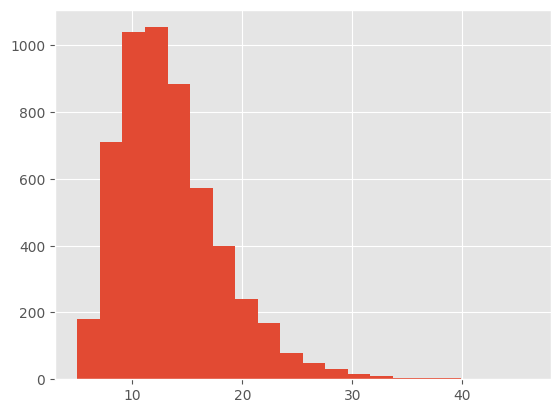

In [ ]:
# Define a Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

#Print the length distribution
plt.style.use("ggplot")
plt.hist([len(tokenizer.encode_plus(text)["input_ids"]) for text, label in train_examples], bins=20)
plt.show()

The training parameters are reported below:

In [ ]:
# --------------------------------
# Encoder (i.e., BERT) parameters
# --------------------------------

# the maximum length to be considered in input
max_seq_length = 64
# dropout applied to the embedding produced by BERT before the classifiation
out_dropout_rate = 0.1

# --------------------------------
# Training parameters
# --------------------------------

# Dev percentage split, i.e., the percentage of training material to be use for
# evaluating the model during training
dev_perc = 0.1

# the batch size
batch_size = 64

# the learning rate used during the training process
learning_rate = 2e-5
# if you use large models (such as Bert-large) it is a good idea to use
# smaller values, such as 5e-6

# name of the fine_tuned_model
output_model_name = "best_model.pickle"

# number of training epochs
num_train_epochs = 5

# ADVANCED: Schedulers allow to define dynamic learning rates.
# You can find all available schedulers here
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html
apply_scheduler = False
# Here a `Constant schedule with warmup`can be activated. More details here
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_constant_schedule_with_warmup
warmup_proportion = 0.1

# --------------------------------
# Log parameters
# --------------------------------

# Print a log each n steps
print_each_n_step = 10


## **Step 5**: Convert data into Dataloader(s)

The following method is used to convert input material into `DataLoader` that will be used to handle examples (during the training and the evaluation phase). Dataloaders are used in PyTorch to handle data, to split it into batches and to shuffle data.
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

First, let us define a function to implement such conversion.

In [ ]:
def generate_data_loader(examples, label_map, tokenizer, do_shuffle = False):
  '''
  Generate a Dataloader given the input examples

  examples: a list of pairs (input_text, label)
  label_mal: a dictionary used to assign an ID to each label
  tokenize: the tokenizer used to convert input sentences into word pieces
  do_shuffle: a boolean parameter to shuffle input examples (usefull in training)
  '''
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_id_array = []

  # Tokenization
  for (text, label) in examples:
    # tokenizer.encode_plus is a crucial method which:
    # 1. tokenizes examples
    # 2. trims sequences to a max_seq_length
    # 3. applies a pad to shorter sequences
    # 4. assigns the [CLS] special wor-piece such as the other ones (e.g., [SEP])
    encoded_sent = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_seq_length, padding='max_length', truncation=True)
    # convert input word pieces to IDs of the corresponding input embeddings
    input_ids.append(encoded_sent['input_ids'])
    # store the attention mask to avoid computations over "padded" elements
    input_mask_array.append(encoded_sent['attention_mask'])

    # converts labels to IDs
    id = -1
    if label in label_map:
      id = label_map[label]
    label_id_array.append(id)

  # Convert to Tensor which are used in PyTorch
  input_ids = torch.tensor(input_ids)
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array)

  if do_shuffle:
    # this will shuffle examples each time a new batch is required
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), # the adopted sampler
              batch_size = batch_size) # Trains with this batch size.


Then, we apply it.


In [ ]:
# Initialize a map to associate labels to the dimension of the embedding
# produced by the classifier
label_to_id_map = {}
id_to_label_map = {}
for (i, label) in enumerate(label_list):
  label_to_id_map[label] = i
  id_to_label_map[i] = label

# Shuffle and split the training material in train/dev
random.shuffle(train_examples)
train_subset_examples = train_examples[int(len(train_examples) * 0) : int(len(train_examples) * (1-dev_perc))]
dev_subset_examples = train_examples[int(len(train_examples) * (1-dev_perc)) : int(len(train_examples))]

# Build the Train Dataloader
train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, do_shuffle = True)
# Build the Development Dataloader
dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, do_shuffle = True)
# Build the Test DataLoader
test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, do_shuffle = False)

print("Number of training examples:\t"+ str(len(train_subset_examples)))
print("Number of development examples:\t"+ str(len(dev_subset_examples)))
print("Number of test examples:\t"+ str(len(test_examples)))


Number of training examples:	4906
Number of development examples:	546
Number of test examples:	500


## **Step 6**: Train the model

Before training the model, let us define the evaluation method which will be applied to development and test datasets

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sys


def evaluate(dataloader, classifier, print_classification_output=False, print_result_summary=False):

  '''
  Evaluation method which will be applied to development and test datasets.
  It returns the pair (average loss, accuracy)

  dataloader: a dataloader containing examples to be classified
  classifier: the BERT-based classifier
  print_classification_output: to log the classification outcomes
  '''
  total_loss = 0
  gold_classes = []
  system_classes = []

  if print_classification_output:
      print("\n------------------------")
      print("  Classification outcomes")
      print("is_correct\tgold_label\tsystem_label\ttext")
      print("------------------------")

  # For each batch of examples from the input dataloader
  for batch in dataloader:
    # Unpack this training batch from our dataloader. Notice this is populated
    # in the method `generate_data_loader`
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
      # Each batch is classifed
      logits, _ = classifier(b_input_ids, b_input_mask)
      # Evaluate the loss.
      total_loss += nll_loss(logits, b_labels)

    # Accumulate the predictions and the input labels
    _, preds = torch.max(logits, 1)
    system_classes += preds.detach().cpu()
    gold_classes += b_labels.detach().cpu()

    # Print the output of the classification for each input element
    if print_classification_output:
      for ex_id in range(len(b_input_mask)):
        input_strings = tokenizer.decode(b_input_ids[ex_id], skip_special_tokens=True)
        # convert class id to the real label
        predicted_label = id_to_label_map[preds[ex_id].item()]
        gold_standard_label = "UNKNOWN"
        # convert the gold standard class ID into a real label
        if b_labels[ex_id].item() in id_to_label_map:
          gold_standard_label = id_to_label_map[b_labels[ex_id].item()]
        # put the prefix "[OK]" if the classification is correct
        output = '[OK]' if predicted_label == gold_standard_label else '[NO]'
        # print the output
        print(output+"\t"+gold_standard_label+"\t"+predicted_label+"\t"+input_strings)

  # Calculate the average loss over all of the batches.
  avg_loss = total_loss / len(dataloader)
  avg_loss = avg_loss.item()

  # Report the final accuracy for this validation run.
  system_classes = torch.stack(system_classes).numpy()
  gold_classes = torch.stack(gold_classes).numpy()
  accuracy = np.sum(system_classes == gold_classes) / len(system_classes)

  if print_result_summary:
    print("\n------------------------")
    print("  Summary")
    print("------------------------")
    #remove unused classes in the test material
    filtered_label_list = []
    for i in range(len(label_list)):
      if i in gold_classes:
        filtered_label_list.append(id_to_label_map[i])
    print(classification_report(gold_classes, system_classes, digits=3, target_names=filtered_label_list))

    print("\n------------------------")
    print("  Confusion Matrix")
    print("------------------------")
    conf_mat = confusion_matrix(gold_classes, system_classes)
    for row_id in range(len(conf_mat)):
      print(filtered_label_list[row_id]+"\t"+str(conf_mat[row_id]))

  return avg_loss, accuracy

Instantiate the classifier and initialize the Optimizer

In [ ]:
classifier = Classifier(model_name, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():
  classifier.cuda()

# Define the Optimizer. Here the ADAM optimizer (a sort of standard de-facto) is
# used. AdamW is a variant which also adopts Weigth Decay.
optimizer = torch.optim.AdamW(classifier.parameters(), lr=learning_rate)
# More details about the Optimizers can be found here:
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html

# Define the scheduler
if apply_scheduler:
  # Estimate the numbers of step corresponding to the warmup.
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)
  # Initialize the scheduler
  scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.37.2",
  "vocab_size": 28996
}



model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/model.safetensors
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of DistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task

This method is used for pretty prints. It takes a time in seconds and returns a string hh:mm:ss

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Now we are **ready to train** our model.  An *epoch* means one pass through the whole training data.

The steps for training/learning from a batch of data are described in the comments below:

*   Clear the gradients of all optimized variables
*   Forward pass: compute predicted outputs by passing inputs to the model
*   Calculate the loss
*   Backward pass: compute gradient of the loss with respect to model parameters
*   Perform a single optimization step (parameter update)
*   Update average training loss

The following loop trains for 10 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

_______________________________________

**Notice**: at the end of each epoch the model is evaluated over the **Development set** and it is saved only if the performance is improved.

In [ ]:
training_stats = []

# Define the LOSS function. A CrossEntropyLoss is used for multi-class
# classification tasks.
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)
# All loss functions are available at:
# - https://pytorch.org/docs/stable/nn.html#loss-functions

# Measure the total training time for the whole run.
total_t0 = time.time()

# NOTICE: the measure to be maximized should depends on the task.
# Here accuracy is used.
best_dev_accuracy = -1

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    train_loss = 0

    # Put the model into training mode.
    classifier.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        train_logits, _ = classifier(b_input_ids, b_input_mask)
        # calculate the loss
        loss = nll_loss(train_logits, b_labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()

        # Update the learning rate with the scheduler, if specified
        if apply_scheduler:
          scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #     Evaluate on the Development set
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    classifier.eval()

    # Apply the evaluate_method defined above to estimate
    avg_dev_loss, dev_accuracy = evaluate(test_dataloader, classifier)

    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)

    print("  Accuracy: {0:.3f}".format(dev_accuracy))
    print("  Test Loss: {0:.3f}".format(avg_dev_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_dev_loss,
            'Valid. Accur.': dev_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )

    # Save the model if the performance on the development set increases
    if dev_accuracy > best_dev_accuracy:
      best_dev_accuracy = dev_accuracy
      torch.save(classifier, output_model_name)
      print("\n  Saving the model during epoch " + str(epoch_i))
      print("  Actual Best Validation Accuracy: {0:.3f}".format(best_dev_accuracy))



======== Epoch 1 / 5 ========
Training...
  Batch    10  of     77.    Elapsed: 0:00:05.
  Batch    20  of     77.    Elapsed: 0:00:08.
  Batch    30  of     77.    Elapsed: 0:00:11.
  Batch    40  of     77.    Elapsed: 0:00:14.
  Batch    50  of     77.    Elapsed: 0:00:17.
  Batch    60  of     77.    Elapsed: 0:00:20.
  Batch    70  of     77.    Elapsed: 0:00:23.

  Average training loss: 0.873
  Training epcoh took: 0:00:25

Running Test...
  Accuracy: 0.940
  Test Loss: 0.205
  Test took: 0:00:01

  Saving the model during epoch 0
  Actual Best Validation Accuracy: 0.940

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     77.    Elapsed: 0:00:03.
  Batch    20  of     77.    Elapsed: 0:00:06.
  Batch    30  of     77.    Elapsed: 0:00:09.
  Batch    40  of     77.    Elapsed: 0:00:12.
  Batch    50  of     77.    Elapsed: 0:00:15.
  Batch    60  of     77.    Elapsed: 0:00:18.
  Batch    70  of     77.    Elapsed: 0:00:21.

  Average training loss: 0.208
  Training

Print some statistics about the training

{'epoch': 1, 'Training Loss': 0.872912356799299, 'Valid. Loss': 0.2047749012708664, 'Valid. Accur.': 0.94, 'Training Time': '0:00:25', 'Test Time': '0:00:01'}
{'epoch': 2, 'Training Loss': 0.20754272606852767, 'Valid. Loss': 0.12608808279037476, 'Valid. Accur.': 0.964, 'Training Time': '0:00:23', 'Test Time': '0:00:01'}
{'epoch': 3, 'Training Loss': 0.10055729550877948, 'Valid. Loss': 0.13220345973968506, 'Valid. Accur.': 0.96, 'Training Time': '0:00:23', 'Test Time': '0:00:01'}
{'epoch': 4, 'Training Loss': 0.046449907075662114, 'Valid. Loss': 0.11127440631389618, 'Valid. Accur.': 0.968, 'Training Time': '0:00:23', 'Test Time': '0:00:01'}
{'epoch': 5, 'Training Loss': 0.03016794493494483, 'Valid. Loss': 0.1178278848528862, 'Valid. Accur.': 0.966, 'Training Time': '0:00:23', 'Test Time': '0:00:01'}


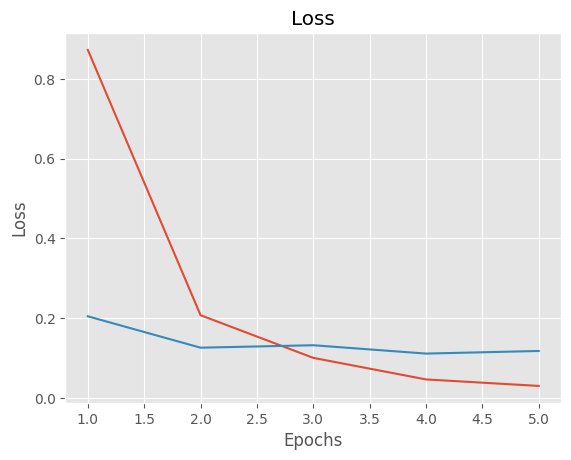

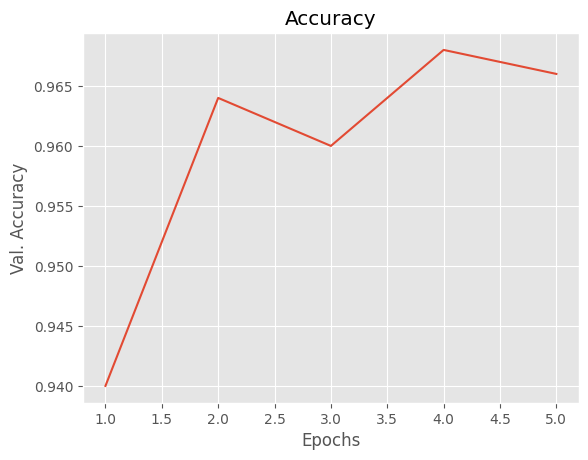


Training complete!
Total training took 0:02:08 (h:mm:ss)


In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for stat in training_stats:
  train_losses.append(stat["Training Loss"])
  val_losses.append(stat["Valid. Loss"])
  val_acc.append(stat["Valid. Accur."])
  print(stat)

plt.plot(range(1,num_train_epochs+1), train_losses, label = "Training Loss")
plt.plot(range(1,num_train_epochs+1), val_losses, label = "Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(range(1,num_train_epochs+1), val_acc, label = "Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Val. Accuracy")
plt.show()

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## **Step 7**: Evaluate the model

We can evaluate the model maximizing the performances over the development set (saved on file).

In [ ]:
# Load the best model
best_model = torch.load(output_model_name)

# Evaluate it
avg_test_loss, test_accuracy = evaluate(test_dataloader, best_model, print_classification_output = True, print_result_summary=True)

print("\n\n  Accuracy: {0:.3f}".format(test_accuracy))
print("  Test Loss: {0:.3f}".format(avg_test_loss))


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[OK]	NUM	NUM	How far is it from Denver to Aspen?
[OK]	LOC	LOC	What county is Modesto, California in?
[OK]	HUM	HUM	Who was Galileo?
[OK]	DESC	DESC	What is an atom?
[OK]	NUM	NUM	When did Hawaii become a state?
[OK]	NUM	NUM	How tall is the Sears Building?
[OK]	HUM	HUM	George Bush purchased a small interest in which baseball team?
[OK]	ENTY	ENTY	What is Australia's national flower?
[OK]	DESC	DESC	Why does the moon turn orange?
[OK]	DESC	DESC	What is autism?
[OK]	LOC	LOC	What city had a world fair in 1900?
[OK]	HUM	HUM	What person's head is on a dime?
[OK]	NUM	NUM	What is the average weight of a Yellow Labrador?
[OK]	HUM	HUM	Who was the first man to fly across the Pacific Ocean?
[OK]	NUM	NUM	When did Idaho become a state?
[OK]	NUM	NUM	What is the life expectancy for crickets?
[OK]	ENTY	ENTY	What metal has the highest melting point?
[OK]	HUM	HUM	Who developed the vaccination a

### **Step 7.1**: use the model over new data

We can apply the best model even to new examples not belonging to any dataset.

In [ ]:
# Let us select a simple example
my_test = "Where is Monte Porzio Catone ?"
#my_test = "il governante, ora in esilio, ritornerà nel paese per le elezioni, merda"
label = "_"

# Let us convert it in a pair that can be used to populate a dataloader...
my_list = [(my_test,label)]
my_data_loader = generate_data_loader(my_list, label_to_id_map, tokenizer)

# ... and reuse the evaluate method
_, _ = evaluate(my_data_loader, best_model, print_classification_output = True)


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[NO]	UNKNOWN	LOC	Where is Monte Porzio Catone?


### **Step 7.2**: Show all examples in PCA or TSNE

Rememenber that the encoder provides embedding to each input example. We can use TSNE and PCA to browse this new task-dependent space.

Some details about these techniques here:
https://www.geeksforgeeks.org/difference-between-pca-vs-t-sne/

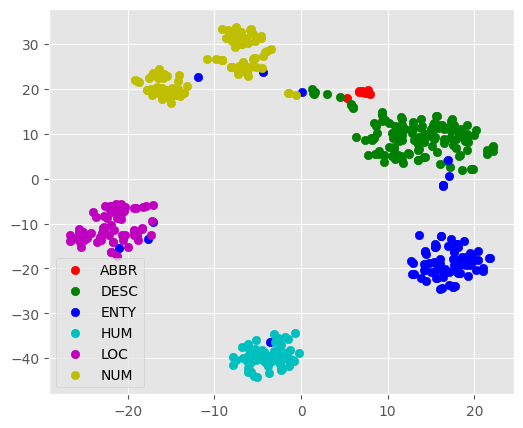

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#!pip install mpld3
%matplotlib inline
import mpld3
mpld3.enable_notebook()


def show_hidden_vectors(dataloader, classifier, label_list, mode="TSNE"):
  x = []
  y = []

  for batch in test_dataloader:
      # Unpack this training batch from our dataloader.
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():
          _, cls_vectors = classifier(b_input_ids, b_input_mask)
          #hidden_states = model_outputs[-1]
          x.extend([t.detach().cpu().numpy() for t in cls_vectors])
          y.extend([t.detach().cpu().item() for t in b_labels])

  if mode == "TSNE":
    approx = TSNE(n_components=2, random_state=seed_val)
  else:
    approx = PCA(n_components=2, random_state=seed_val)

  X_2d = approx.fit_transform(np.asarray(x))
  y = np.asarray(y)

  #print(y)

  target_ids = range(len(label_list))

  plt.figure(figsize=(6, 5))
  colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
  for i, c, label in zip(target_ids, colors, label_list):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
  plt.legend()
  plt.show()

show_hidden_vectors(test_dataloader, best_model, label_list, mode = "TSNE")
#show_hidden_vectors(test_dataloader, best_model, label_list, mode = "PCA")

## **Step 8**: Take a look on this bibliography concerning pre-trained Language Models, Transformers and BERT

https://github.com/thunlp/PLMpapers